# Building a less biased feature extraction algorithm

## Import analysis tools


The tools used in this analysis are: NumPy, Scipy, Matplotlib, Scikit-Learn, and Theano.

In [7]:
from __future__ import division
import numpy as np
from numpy.linalg import svd,norm
from scipy.io import loadmat
from sklearn.feature_extraction import image
from sklearn.decomposition import FastICA

#my modules
import ica as ocica 
reload(ocica)
from utils import tile_raster_images as tri
from visualizations import *
import visualizations as vz
reload(vz)

import matplotlib as mpl
import matplotlib.pyplot as plt

# Set some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['legend.fontsize'] = 20

# Enable inline plotting
%matplotlib inline

## Load and visualize the data

The dataset is composed by 10 black and white images.  

In [8]:
images = loadmat('IMAGES_RAW.mat')['IMAGESr']

We performa a visual inspection of the dataset. Here, we just plot one image.

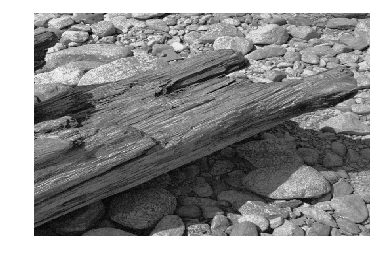

In [9]:
plt.imshow(images[...,0])
plt.gca().set_axis_off()
plt.show()

## Data preprocessing 

Select small image windows (specific to the type of data).

In [10]:
n_dimensions = 64                      # Total number of pixels
im_size = int(np.sqrt(n_dimensions))   # Size of the image patches in pixels
total_samples = 16000                  # Number of samples 
rng = np.random.RandomState(1234)      # Initializes the pseudo-random number generator
patches = image.PatchExtractor(patch_size=(im_size, im_size),\
                               max_patches=total_samples//images.shape[-1],
                               random_state=rng).transform(images.T)
X = patches.reshape((total_samples,n_dimensions)).T

Remove the offset.

In [11]:
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean

Removing correlations in the data (specific to the method).

In [12]:
def decorrelate(X):
    """Decorrelates and array of images using SVD
    
    Parameters:
    ----------
    X : ndarray
        Set of images
        Dimensions: n_pixels X n_samples

    Returns:
    --------
    X_pca: ndarray
        Decorrelated images
        Dimensions: n_pixels X n_samples
    K: ndarray
        Decorrelating matrix
        Dimensions: n_pixels X n_pixels
    """    
    u, d, _ = svd(X, full_matrices=False)
    del _
    K = (u/d).conj().T
    del u,d
    X_pca = K.dot(X)
    X_pca*=np.sqrt(total_samples)

    return X_pca, K

In [13]:
X_pca, K = decorrelate(X)

## Feature extraction

The algorithm implementation using object-oriented Python and Theano

In [14]:
from collections import OrderedDict
from scipy.optimize import minimize
import theano
import theano.tensor as T
from theano.compat.python2x import OrderedDict

def sgd(params, grads, learning_rate=1.):
    updates = OrderedDict()
    for param, grad in zip(params, grads):
        updates[param] = param - learning_rate * grad
    return updates

def momentum(params, grads, learning_rate=1., momentum=.5,
             nesterov=True):
    """
    Nesterov momentum based on pylearn2 implementation.
    """
    updates = OrderedDict()
    for param, grad in zip(params, grads):
        v = theano.shared(0.*param.get_value())
        updates[v] = v * momentum - learning_rate * grad
        delta = v
        if nesterov:
            delta = momentum * delta - learning_rate * grad
        updates[param] = param + delta
    return updates

def adam(params, grads, learning_rate=0.001, beta1=0.9,
         beta2=0.999, epsilon=1e-8):

    updates = OrderedDict()
    t_0 = theano.shared(np.array(0.).astype('float32'))
    one = T.constant(1)

    t = t_0 + 1
    a_t = learning_rate*T.sqrt(one-beta2**t)/(one-beta1**t)

    for param, grad in zip(params, grads):
        m_prev = theano.shared(0.*param.get_value())
        v_prev = theano.shared(0.*param.get_value())

        m_t = beta1*m_prev + (one-beta1)*grad
        v_t = beta2*v_prev + (one-beta2)*grad**2
        step = a_t*m_t/(T.sqrt(v_t) + epsilon)

        updates[m_prev] = m_t
        updates[v_prev] = v_t
        updates[param] = param - step

    updates[t_0] = t
    return updates


class Optimizer(object):
    """
    Optimizer.
    """
    def __init__(self, **fit_kwargs):
        self.fit_kwargs = fit_kwargs
        self.setup(**fit_kwargs)
        self.setup_transforms(**fit_kwargs)

    def fit(self, data, components_):
        raise NotImplementedError

    def transforms(self, W, X):
        S = W.dot(X)
        X_hat = W.T.dot(S)
        return S, X_hat

    def setup_transforms(self, **kwargs):
        """
        Create transform_f and reconstruct_f functions.
        """
        X = T.matrix('X')
        W = T.matrix('W')
        epssumsq = T.maximum((W**2).sum(axis=1, keepdims=True), 1e-7)
        W_norm = T.sqrt(epssumsq)
        Wn = W / W_norm
        
        S, X_hat = self.transforms(Wn, X)

        self.transform = theano.function(inputs=[X, W], outputs=[S])
        self.reconstruct = theano.function(inputs=[X, W], outputs=[X_hat])

        loss, error, penalty, mse, S, X_hat = self.cost(Wn, X, **kwargs)
        outputs = [loss, error, penalty, mse]
        outputs = [o if o is not None else 0.* loss for o in outputs]

        self.losses_f = theano.function(inputs=[X, W],
                                        outputs=outputs)
    def losses(self, X, W):
        return self.losses_f(X.astype('float32'), W.astype('float32'))
        
    def cost(self, Wn, X, degeneracy=None, lambd=0.,
             a=None, p=None, **kwargs):
        """
        Create costs and intermediate values from input variables.
        """
        S, X_hat = self.transforms(Wn, X)
        gram = T.dot(Wn, Wn.T)
        gram_diff = gram-T.eye(gram.shape[0])
        loss = None
        assert lambd >= 0.

        if degeneracy == 'L2':
            degeneracy = 'Lp'
            p = 2
        elif degeneracy == 'L4':
            degeneracy = 'Lp'
            p = 4

        if degeneracy == 'RICA':
            error = .5 * T.sum((X_hat-X)**2, axis=0).mean()
        elif degeneracy == 'Lp':
            assert isinstance(p, int)
            assert (p % 2) == 0
            error = gram_diff
            for ii in range(p//2):
                error = error**2
            error = (1./p) * T.sum(error)
        elif degeneracy == 'COULOMB':
            epsilon = 0.1
            error = .5 * T.sum(1. / T.sqrt(1. + epsilon - gram**2))
        elif degeneracy == 'COULOMB_A':
            assert a is not None
            epsilon = 0.1
            error = .5 * T.sum((1. / (1. + epsilon - gram**2)**(1 / a)) - (gram**2 / a))
        elif degeneracy == 'RANDOM':
            epsilon = 0.1
            error = -.5 * T.sum(T.log(1. + epsilon - gram**2))
        elif degeneracy == 'RANDOM_A':
            epsilon = 0.1
            error = -.5 * T.sum(T.log(1. + epsilon - gram**2) - gram**2)
        elif degeneracy == 'COHERENCE':
            error = abs(gram_diff).max()
        elif degeneracy is None:
            error = None
        else:
            raise ValueError

        if ((degeneracy is not None) and
            (lambd == 0. or lambd > 0.) and
            not np.isinf(lambd)):
            loss = error

        if np.isinf(lambd) or degeneracy is None:
            penalty = T.log(T.cosh(S)).sum(axis=0).mean()
            loss = penalty
        elif lambd > 0.:
            penalty = T.log(T.cosh(S)).sum(axis=0).mean()
            loss += lambd * penalty
        else:
            penalty = None

        X_normed = X/T.sqrt((X**2).sum(axis=0, keepdims=True))
        X_hat_normed = X_hat/T.sqrt((X_hat**2).sum(axis=0, keepdims=True))
        mse = ((X_normed-X_hat_normed)**2).sum(axis=0).mean()
        return loss, error, penalty, mse, S, X_hat


class LBFGSB(Optimizer):
    def setup(self, n_sources, n_mixtures, degeneracy, lambd, a, p):
        """
        L-BFGS-B Optimization
        """
        X = theano.shared(np.zeros((1, 1), dtype='float32'))
        self.X = X
        Wv = T.vector('W')
        W  = T.reshape(Wv,(n_sources, n_mixtures))
        epssumsq = T.maximum((W**2).sum(axis=1, keepdims=True), 1e-7)
        W_norm = T.sqrt(epssumsq)
        Wn = W / W_norm

        loss, error, penalty, mse, S, X_hat = self.cost(Wn, X, degeneracy,
                                                        lambd, a, p)
        loss_grad = T.grad(loss, Wv)

        X_normed = X/T.sqrt((X**2).sum(axis=0, keepdims=True))
        X_hat_normed = X_hat/T.sqrt((X_hat**2).sum(axis=0, keepdims=True))
        mse = ((X_normed-X_hat_normed)**2).sum(axis=0).mean()

        self.f_df = theano.function(inputs=[Wv], outputs=[loss,loss_grad])
        if error is None:
            error = 0.*loss
        if penalty is None:
            penalty = 0.*loss
        self.callback_f = theano.function(inputs=[Wv],
                                          outputs=[loss, error, penalty, mse])

    def fit(self, data, components_):
        """
        Fit components_ from data.
        """
        def callback(w):
            res = self.callback_f(w.astype('float32'))
            print('Loss: {}, Error: {}, Penalty: {}, MSE: {}'.format(*res[:4]))
        self.X.set_value(data.astype('float32'))
        w = components_.ravel()
        float_f_df = lambda w: tuple([r.astype('float64') for r in
                                self.f_df(w.astype('float32'))])
        res = minimize(float_f_df, w, jac=True, method='L-BFGS-B', callback=callback)
        w_f = res.x
        l, g = float_f_df(w_f)
        print('ICA with L-BFGS-B done!')
        print('Final loss value: {}'.format(l))
        return w_f.reshape(components_.shape)


class SGD(Optimizer):
    def setup(self, n_sources, n_mixtures, w_0, lambd, degeneracy,
              learning_rule, a, p):
        """
        SGD optimization
        """
        print n_sources
        X = T.matrix('X')
        W  = theano.shared(np.random.randn(n_sources, n_mixtures).astype('float32'))
        self.W = W
        epssumsq = T.maximum((W**2).sum(axis=1, keepdims=True), 1e-7)
        W_norm = T.sqrt(epssumsq)
        Wn = W / W_norm
        
        loss, error, penalty, mse, S, X_hat = self.cost(Wn, X, degeneracy,
                                                        lambd, a, p)
        loss_grad = T.grad(loss, W)
        updates = learning_rule([W], [loss_grad])

        X_normed = X/T.sqrt((X**2).sum(axis=0, keepdims=True))
        X_hat_normed = X_hat/T.sqrt((X_hat**2).sum(axis=0, keepdims=True))
        mse = ((X_normed-X_hat_normed)**2).sum(axis=0).mean()
        if error is None:
            error = 0.*loss
        if penalty is None:
            penalty = 0.*loss

        self.train_f = theano.function(inputs=[X],
                                       outputs=[loss, error, penalty, mse],
                                       updates=updates)
        return W, self.train_f

    def fit(self, data, components_,
            tol=1e-5, batch_size=512, n_epochs=1000,
            seed=20160615):
        """
        Fit components_ from data.
        """
        n_examples = data.shape[1]
        rng = np.random.RandomState(seed)
        self.W.set_value(components_.astype('float32'))
        n_batches = n_examples//batch_size
        if n_batches * batch_size < n_examples:
            n_batches += 1

        lowest_cost = np.inf

        for ii in range(n_epochs):
            order = rng.permutation(n_examples)
            cur_cost = 0.
            error = 0.
            penalty = 0.
            mse = 0.
            for jj in range(n_batches):
                start = jj * batch_size
                end = (jj + 1) * batch_size
                batch = data[:, order[start:end]].astype('float32')
                res = self.train_f(batch)
                cur_cost += res[0]*batch.shape[1]
                error += res[1]*batch.shape[1]
                penalty += res[2]*batch.shape[1]
                mse += res[3]*batch.shape[1]
            cur_cost /= n_examples
            error /= n_examples
            penalty /= n_examples
            mse /= n_examples
            print('Loss: {}, Error: {}, Penalty: {}, MSE: {}'.format(cur_cost,
                error, penalty, mse))
            if cur_cost < lowest_cost-tol or True:
                lowest_cost = cur_cost
            else:
                break

        print('ICA with SGD done!')
        print('Final loss value: {}'.format(cur_cost))
        return self.W.get_value()

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ICA(BaseEstimator, TransformerMixin):
    """
    ICA class.

    Parameters
    ----------
    n_mixtures : int
        Dimensionality of mixtures.
    n_sources : int
        Dimensionality of sources.
    lambd : float
        Coefficient for sparse penalty.
    w_init : ndarray
        Initialization for filter matrix.
    degeneracy : str
        Type of degeneracy control to use.
    p : int
        p for 'Lp' norm degeneracy control.
    rng : numpy.RandomState
        Randomstate for initialization.
    a : int
        Inverse power for Coulomb cost.
    optimizer : str
        Type of optimizer. 'L_BFGS-B' or 'sgd'.
    learning_rule : str
        Type of learning rule for sgd.
    fit_kwargs : str
        kwargs for optimizer.
    """
    def __init__(self, n_mixtures, n_sources=None, lambd=1e-2,
                 w_init=None, degeneracy=None, p=None, rng=None,
                 a=None, optimizer='L-BFGS-B', learning_rule=None,
                 **fit_kwargs):

        if learning_rule is not None:
            assert optimizer == 'sgd'

        if rng is None:
            seed = np.random.randint(100000)
            print('Random seed: {}'.format(seed))
            rng = np.random.RandomState(seed)

        if n_sources==None:
            n_sources = n_mixtures
            print('Complete ICA')
        else:
            if n_sources > n_mixtures:
                print('Overcomplete ICA')
        print('Degeneracy control: {}'.format(degeneracy))

        self.fit_kwargs = fit_kwargs

        if w_init is None:
            w_0 = rng.randn(n_sources, n_mixtures)
        else:
            w_0 = w_init
        w_0 = w_0/np.sqrt(np.maximum((w_0**2).sum(axis=1, keepdims=True), 1e-7))
        self.n_mixtures = n_mixtures
        self.n_sources = n_sources
        self.components_ = w_0
        if optimizer == 'L-BFGS-B':
            self.optimizer = LBFGSB(n_sources=n_sources, n_mixtures=n_mixtures,
                                               degeneracy=degeneracy,
                                               lambd=lambd, p=p, a=a)
        elif optimizer == 'sgd':
            self.optimizer = SGD(n_sources=n_sources, n_mixtures=n_mixtures,
                                            w_0=w_0, lambd=lambd,
                                            degeneracy=degeneracy,
                                            learning_rule=learning_rule,
                                            p=p, a=a)
        else:
            raise ValueError

    def _normalize_components(self):
        """
        Normalize components_ to unit norm.
        """
        self.components_ = self.components_/np.linalg.norm(self.components_, axis=-1, keepdims=True)

    def fit(self, X, y=None):
        """
        Fit an ICA model to data.

        Parameters
        ----------
        X : ndarray
            Data array (mixtures by samples)
        """
        self._normalize_components()
        w_f = self.optimizer.fit(X, self.components_)
        self.components_ = w_f
        self._normalize_components()
        return self

    def transform(self, X, y=None):
        """
        Transform data into sources.

        Parameters
        ----------
        X : ndarray
            Data array (mixtures by samples)

        Returns
        -------
        sources : ndarray
            Data transformed into sources.
        """
        self._normalize_components()
        sources = self.optimizer.transform(X, self.components_)
        return sources

    def fit_transform(self, X, y=None):
        """
        Fit an ICA model to data and returns transformed data.

        Parameters
        ----------
        X : ndarray
            Data array (mixtures by samples)

        Returns
        -------
        sources : ndarray
            Data transformed into sources.
        """
        self._normalize_components()
        self.fit(X)
        self._normalize_components()
        return self.transform(X)

    def reconstruct(self, X):
        """
        Reconstruct data with model.

        Parameters
        ----------
        X : ndarray
            Data array (mixtures by samples)

        Returns
        -------
        X_hat : ndarray
            Data transformed into sources.
        """
        self._normalize_components()
        X_hat = self.optimizer.reconstruct(X, self.components_)
        return X_hat

    def losses(self, X):
        """
        Return the loss, error, penalty, and mse.

        Parameters
        ----------
        X : ndarray
            Data array (mixtures by samples)

        Returns
        -------
        losses : ndarray
            Loss for each data sample.
        """
        self._normalize_components()
        losses = self.optimizer.losses(X, self.components_)
        return losses

In [16]:
def learn_features(X, K, costs=['L2','COULOMB','RANDOM','L4'],oc=4,lambd=10.):
    """Learn ICA features for a given set of non-degeneracy costs
    Parameters:
    ----------
    X     : ndarray
           Whiten data. Dimension: n_samples X n_features
    oc    : int, optional
           Overcompleteness 
    lambd : float, optional
           Sparsity
    """
    n_mixtures = X.shape[0]
    n_sources  = n_mixtures*oc
    bases = np.zeros((len(costs),n_sources,n_mixtures))
    for i in xrange(len(costs)):
        ica = ICA(n_mixtures=n_mixtures,n_sources=n_sources,lambd=lambd,
                        degeneracy=costs[i],optimizer='L-BFGS-B')
        ica.fit(X)
        bases[i] = ica.components_.dot(K)
    return bases

In [17]:
overcompleteness = 4
degeneracy_control = ['L2','L4']
bases = learn_features(X_pca, K, costs=degeneracy_control, oc=overcompleteness, lambd=10.)

Random seed: 37908
Overcomplete ICA
Degeneracy control: L2
Loss: 1295.21728516, Error: 457.63104248, Penalty: 83.7586212158, MSE: 0.128721863031
Loss: 1223.70349121, Error: 387.795410156, Penalty: 83.5908050537, MSE: 0.00881631113589
Loss: 1220.51513672, Error: 384.985931396, Penalty: 83.5529251099, MSE: 0.00348848546855
Loss: 1219.74499512, Error: 384.825073242, Penalty: 83.4919891357, MSE: 0.00314250704832
Loss: 1218.33007812, Error: 385.214172363, Penalty: 83.3115844727, MSE: 0.00386202009395
Loss: 1215.08068848, Error: 387.073181152, Penalty: 82.8007507324, MSE: 0.00750760687515
Loss: 1210.44995117, Error: 388.739074707, Penalty: 82.1710891724, MSE: 0.0109304776415
Loss: 1205.15356445, Error: 385.358978271, Penalty: 81.9794540405, MSE: 0.00418476993218
Loss: 1203.87316895, Error: 384.858856201, Penalty: 81.9014358521, MSE: 0.00298074120656
Loss: 1202.23291016, Error: 385.074188232, Penalty: 81.7158660889, MSE: 0.00320329144597
Loss: 1198.54785156, Error: 386.868499756, Penalty: 81.

## Feature analysis

Visualization of the features

In [18]:
def plot_bases(bases,figsize=None):
    """Plots a basis set
    
    Parameters:
    ----------
    bases : ndarray
           Set of basis.
           Dimension: n_costs X n_vectors X n_dims
    figname: string, optional
           Name of the figure
    """
    n_pixels = int(np.sqrt(bases.shape[1]))
    n_bases  = int(np.sqrt(bases.shape[0]))
    if figsize is None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=figsize)
    fig.clf()
    ax = plt.axes()
    im = tri(bases,(n_pixels,n_pixels),(n_bases,n_bases),
                (2,2), scale_rows_to_unit_interval=False,
                output_pixel_vals=False)
    ax.imshow(im)
    ax.set_axis_off()
    plt.show()

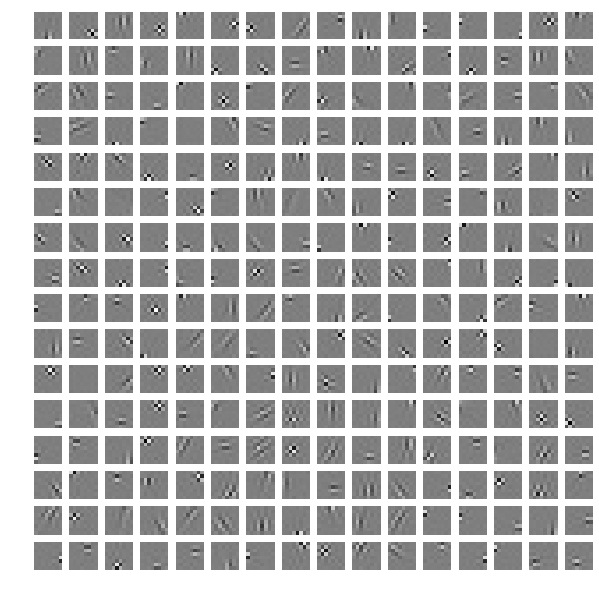

In [19]:
plot_bases(bases[0],figsize=(10,10))

Parameter fitting and visualization of the parameter distribution 

In [14]:
#params = get_Gabor_params(bases)

0.0 4.71238898038 0.242745048561 0.222953565528
0.448798950513 4.71238898038 0.230083123444 0.222679145634
0.897597901026 4.71238898038 0.242979082129 0.22266342774
1.34639685154 4.71238898038 0.253371899953 0.222658860076
1.79519580205 4.71238898038 0.253025299961 0.222632585458
2.24399475256 4.71238898038 0.242446216047 0.222546087586
2.69279370308 4.71238898038 0.253430788103 0.222541366609
3.14159265359 4.71238898038 0.240885430777 0.22253238258
0.0 4.71238898038 0.305369123712 0.192483202816
0.448798950513 4.71238898038 0.269078921831 0.192466398189
0.897597901026 4.71238898038 0.285975118887 0.192463548515
1.34639685154 4.71238898038 0.31345561691 0.192460760082
1.79519580205 4.71238898038 0.362737878758 0.19246075261
2.24399475256 4.71238898038 0.308817479503 0.192440348064
2.69279370308 4.71238898038 0.287192294331 0.192440208176
3.14159265359 4.71238898038 0.299838495494 0.192437998522
0.0 4.71238898038 0.434030989333 0.190233894568
0.448798950513 4.71238898038 0.432770659773 

In [17]:
#from h5py import File
#with File('Gabor_parameters.h5','w') as f:
#    f.create_dataset(name='params_l2',data=params[0][1])
#    f.create_dataset(name='params_l4',data=params[1][1])

In [20]:
from h5py import File
with File('Gabor_parameters.h5','r') as f:
    params_l2 = f['params_l2'].value
    params_l4 = f['params_l4'].value

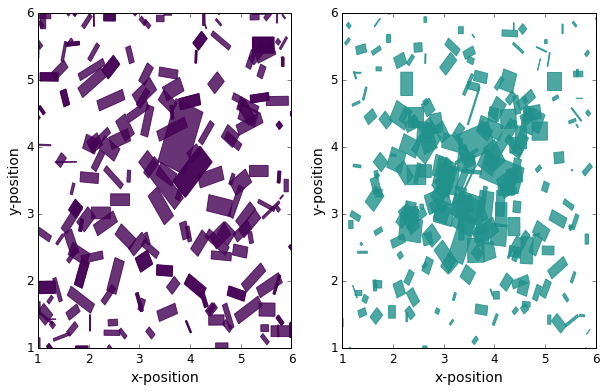

In [21]:
fig  = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
vz.plot_GaborFit_xy(params_l2,figsize=(5,5),color=.0,ax=ax1)
ax2 = fig.add_subplot(122)
vz.plot_GaborFit_xy(params_l4,figsize=(5,5),color=.5,ax=ax2)

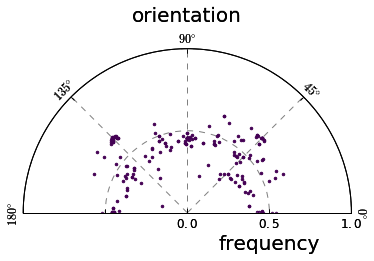

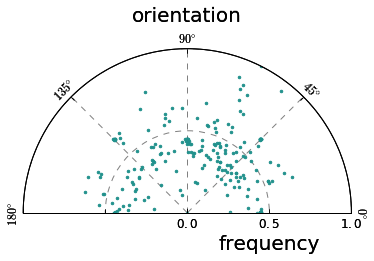

In [22]:
plot_GaborFit_polar(params_l2,figsize=(6,6),color=.0)
plot_GaborFit_polar(params_l4,figsize=(6,6),color=.5)